Leitura dos pacotes

In [49]:
%pip install lxml
%pip install unidecode
import os
import sys
import shutil
import xml.etree.ElementTree as ET
import nltk
from nltk.tokenize import RegexpTokenizer
from unidecode import unidecode
import pandas as pd
import pickle
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import csv
import pandas as pd
import logging
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import re


Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\luanc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Data Prep

Retornar para pasta raiz, assumindo execução da pasta "./src". Se não for o caso alterar para os.chdir(pasta_raiz)

In [50]:
os.chdir('..')

In [51]:
if os.path.exists("RESULT"):
    shutil.rmtree("RESULT") #Remove result folder and all files in it.
os.makedirs("RESULT")

In [52]:
logger = logging.getLogger(__name__)

f_handler = logging.FileHandler('./RESULT/logs.log', mode='w')
f_handler.setLevel(logging.DEBUG)
logger.setLevel(logging.DEBUG)

f_format = logging.Formatter("%(levelname)s: %(message)s")
f_handler.setFormatter(f_format)

logger.addHandler(f_handler)

In [53]:
def check_error():
    with open('RESULT/logs.log', 'r') as f:
        log_content = f.read()
    if 'ERROR' in log_content:
        logger.critical("Execution interrupted. Adjust informed erros")
        f.close()
        sys.exit(1)

In [54]:
config_files = {
    "gli": {"field": ["LEIA","ESCREVA"]},
    "busca": {"field": ["MODELO", "CONSULTAS", "RESULTADOS"]},
    "pc": {"field": ["LEIA", "CONSULTAS", "ESPERADOS"]}, #read only once
    "index": {"field": ["LEIA","ESCREVA"]}  #read only once
}

In [55]:
cfg_file = "gli.cfg"
logger.info("Reading config file " + cfg_file)

with open(os.path.join("config_files", cfg_file), "r") as f:
    lines = f.readlines()
    fields = [config_files[name]['field'] for name in config_files if cfg_file.endswith(name + '.cfg')][0]
    gli_read = []
    for line in lines:
    # check if line has format "field=file_path"
        field, file_path = line.strip().split('=')
        # if field is 'LEIA', add file_path to gli_read
        if field == 'LEIA':
            gli_read.append(file_path)
            # check if file_path exists
            if not os.path.exists(file_path):
                logger.error(f"Error: {file_path} doesn't exist")
        # if field is 'ESCREVA', check that it is the last field
        elif field == 'ESCREVA':
            if field not in fields[-1]:
                logger.error(f"Error: {field} field should be the last field in {cfg_file}")
            gli_write = file_path
        # if field is not 'LEIA' or 'ESCREVA', print error
        elif field not in fields:
            logger.error(f"Error: {field} is not a valid field in {cfg_file}")
    # check that all LEIA files exist
    for leia_file in gli_read:
        if not os.path.exists(leia_file):
            print(f"Error: {leia_file} doesn't exist")
    # check that all fields are present
    if set(fields) != set(['LEIA', 'ESCREVA']):
        print(f"Error: {cfg_file} should have only 'LEIA' and 'ESCREVA' fields")

FileNotFoundError: [Errno 2] No such file or directory: 'config_files\\gli.cfg'

In [ ]:
cfg_file = "busca.cfg"
logger.info("Reading config file " + cfg_file)

busca_model = None
busca_queries = None
busca_results = None

with open(os.path.join("config_files", cfg_file), "r") as f:
    lines = f.readlines()
    fields = [config_files[name]['field'] for name in config_files if cfg_file.endswith(name + '.cfg')][0]
    for line in lines:
        # check if line has format "field=file_path"
        field, file_path = line.strip().split('=')
        # if field is 'LEIA', add file_path to gli_read
        if field == 'MODELO':
            if busca_model != None:
                logger.error(f"Repeated field in {cfg_file}")
            busca_model = file_path
            
        # if field is 'ESCREVA', check that it is the last field
        elif field == 'CONSULTAS':
            if busca_queries != None:
                logger.error(f"Repeated field in {cfg_file}")
            busca_queries = file_path

        elif field == 'RESULTADOS':
            if busca_results != None:
                logger.error(f"Repeated field in {cfg_file}")
            busca_results = file_path

        # if field is not correct, log error
        elif field not in fields:
            logger.error(f"Error: {field} is not a valid field in {cfg_file}")
    # check that all fields are present
    if set(fields) != set(['MODELO', 'CONSULTAS','RESULTADOS']):
        logger.error(f"Error in {cfg_file} adjust fields accordingly")

In [ ]:
cfg_file = "index.cfg"
logger.info("Reading config file " + cfg_file)

index_read = None
index_write = None

with open(os.path.join("config_files", cfg_file), "r") as f:
    lines = f.readlines()
    fields = [config_files[name]['field'] for name in config_files if cfg_file.endswith(name + '.cfg')][0]
    for line in lines:    
    # check if line has format "field=file_path"
        field, file_path = line.strip().split('=')
        
        if field == 'LEIA':
            if index_read != None:
                logger.error(f"Repeated field in {cfg_file}")
            index_read = file_path
        
        elif field == 'ESCREVA':
            # if field is 'ESCREVA', check that it is the last field
            if field not in fields[-1]:
                logger.error(f"Error: {field} field should be the last field in {cfg_file}")
            if index_write != None:
                logger.error(f"Repeated field in {cfg_file}")
            index_write = file_path
        # if field is not 'LEIA' or 'ESCREVA', print error
        elif field not in fields:
            logger.error(f"Error: {field} is not a valid field in {cfg_file}")
    # check that all LEIA files exist
    for leia_file in gli_read:
        if not os.path.exists(leia_file):
            logger.error(f"Error: {leia_file} doesn't exist")
    # check that all fields are present
    if set(fields) != set(['LEIA', 'ESCREVA']):
        logger.error(f"Error: {cfg_file} should have only 'LEIA' and 'ESCREVA' fields")

In [ ]:
cfg_file = "pc.cfg"
logger.info("Reading config file " + cfg_file)

pc_read = None
pc_queries = None
pc_expected = None

with open(os.path.join("config_files", cfg_file), "r") as f:
    lines = f.readlines()
    fields = [config_files[name]['field'] for name in config_files if cfg_file.endswith(name + '.cfg')][0]
    for line in lines:
        # check if line has format "field=file_path"
        field, file_path = line.strip().split('=')
        # if field is 'LEIA', add file_path to gli_read
        if field == 'LEIA':
            if pc_read != None:
                logger.error(f"Repeated field in {cfg_file}")
            pc_read = file_path
            
        # if field is 'ESCREVA', check that it is the last field
        elif field == 'CONSULTAS':
            if pc_queries != None:
                logger.error(f"Repeated field in {cfg_file}")
            pc_queries = file_path

        elif field == 'ESPERADOS':
            if pc_expected != None:
                logger.error(f"Repeated field in {cfg_file}")
            pc_expected = file_path

        # if field is not correct, print error
        elif field not in fields:
            logger.error(f"Error: {field} is not a valid field in {cfg_file}")
    # check that all fields are present
    if set(fields) != set(['LEIA', 'CONSULTAS','ESPERADOS']):
        logger.error(f"Error: {cfg_file} adjust fields accordingly")


In [ ]:
check_error()

In [ ]:
print(f"Generate inverse list read file(s): {gli_read}")
print(f"Generate inverse list write file: {gli_write}")
print(f"Searcher model: {busca_model}")
print(f"Searcher queries: {busca_queries}")
print(f"Searcher results: {busca_results}")
print(f"Query processor read file: {pc_read}")
print(f"Query processor query file: {pc_queries}")
print(f"Query processor expected file: {pc_expected}")
print(f"Index read file: {index_read}")
print(f"Index write file: {index_write}")

Generate inverse list read file(s): ['CysticFibrosis2-20230331/data/cf74.xml', 'CysticFibrosis2-20230331/data/cf75.xml', 'CysticFibrosis2-20230331/data/cf76.xml', 'CysticFibrosis2-20230331/data/cf77.xml', 'CysticFibrosis2-20230331/data/cf78.xml', 'CysticFibrosis2-20230331/data/cf79.xml']
Generate inverse list write file: RESULT/LISTA INVERSA.csv
Searcher model: RESULT/ModeloTFIDF.pkl
Searcher queries: RESULT/CONSULTAS.csv
Searcher results: RESULT/RESULTADOS.csv
Query processor read file: CysticFibrosis2-20230331/data/cfquery.xml
Query processor query file: RESULT/CONSULTAS.csv
Query processor expected file: RESULT/ESPERADOS.csv
Index read file: RESULT/LISTA INVERSA.csv
Index write file: RESULT/ModeloTFIDF.pkl


In [ ]:
paths = gli_read + [gli_write] + [busca_model] + [busca_queries] + [busca_results] + [pc_read] + [pc_queries] + [pc_expected] + [index_read] + [index_write]
for file_path in paths:
    dir_path = os.path.dirname(file_path)
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

Module 1 - Query Processor

In [ ]:
logger.info("Module 1: Query processor started")
def process_query_text(query):
    words = word_tokenize(query)

    # Join the words back into a single string
    processed_query = " ".join(words)
    # Convert the processed query to uppercase
    processed_query = processed_query.upper()

    return processed_query

In [ ]:
def read_queries():
    query_file = pc_read
    logger.info("Reading file " + query_file)

    
    tree = ET.parse(query_file)
    root = tree.getroot()

    queries = {}

    for query in root.iter("QUERY"):
        query_number = int(query.find("QueryNumber").text)
        query_text = re.sub('\s+', ' ',query.find("QueryText").text.strip().replace(";", " "))
        num_results = int(query.find("Results").text)

        query_text = process_query_text(query_text)

        queries[query_number] = {
            "query_text": query_text,
            "num_results": num_results
        }

        expected_results = {}

        for item in query.iter("Item"):
            expected_result = int(item.text)
            expected_score = 0

            for value in item.get("score"):
                expected_score += int(value)

            expected_results[expected_result] = expected_score
            expected_results
        queries[query_number]["expected_results"] = expected_results
    return queries

In [ ]:
def write_queries(queries):
    query_data_list = []
    
    for query_number, query_data in queries.items():
        expected_results = query_data["expected_results"]

        expected_results_str = ";".join([f"{doc_num}:{doc_votes}" for doc_num, doc_votes in expected_results.items()])
        query_data_list.append({"QueryNumber": query_number, "QueryText": query_data["query_text"], "NumResults": query_data["num_results"], "ExpectedResults": expected_results_str})

    queries_df = pd.DataFrame(query_data_list, columns=["QueryNumber", "QueryText"])

    processed_queries_file = pc_queries
    queries_df.to_csv(processed_queries_file, index=False, sep=";")
    logger.info("%d queries read and written to %s." % (queries_df.shape[0], processed_queries_file))


In [ ]:
def write_expected(queries):
    logger.info("Writing expected results.")
    if len(queries.keys()) == 0:
        logger.error("Method 'read_and_write_queries' must be executed first.")
        return

    expected_results_list = []

    for query_number in sorted(queries.keys()):
        expected_results = queries[query_number]["expected_results"]
        for document_number in sorted(expected_results, key = expected_results.get, reverse = True):
            expected_results_list.append({"QueryNumber": query_number, "DocNumber": document_number, "DocVotes": str(expected_results[document_number])})
    
    expected_results_df = pd.DataFrame(expected_results_list, columns=["QueryNumber", "DocNumber","DocVotes"])

    expected_results_file = pc_expected
    expected_results_df.to_csv(expected_results_file, index=False, sep=";")
    logger.info("%d expected results written to '%s'." % (expected_results_df.shape[0], expected_results_file))

In [ ]:
def pc_module_run():
    queries = read_queries()
    write_queries(queries)
    write_expected(queries)


Run Module 1

In [ ]:
pc_module_run()
logger.info("Module 1: Query processor finished")

Module 2 - Invert List Generator

In [ ]:
logger.info("Module 2: Inverted List Generator started")

def read_input_files():
    input_documents = {}

    for path in gli_read:
        logger.info("Reading file " + path)

        tree = ET.parse(path)
        root = tree.getroot()

        for document in root.iter("RECORD"):
            doc_identifier = document.find("RECORDNUM")
            doc_text = document.find("ABSTRACT")

            if doc_identifier is not None:
                doc_identifier = int(doc_identifier.text.strip())
            else:
                logger.warning("RECORDNUM not found for a doc in  %s" %path)
                continue
            if doc_text is None:
                doc_text = document.find("EXTRACT")

                if doc_text is None:
                    logger.warning("Document %d in %s without ABSTRACT and EXTRACT." %(doc_identifier, path))
                    continue

            doc_text = doc_text.text.strip()

            # logs reading document

            input_documents[doc_identifier] = doc_text

    return input_documents

In [ ]:
def generate_inverted_list(input_documents):
    inverted_list = {}
    
    for document_id in sorted(input_documents.keys()):
        text = input_documents[document_id].upper()
        tokenizer = RegexpTokenizer(r'[a-zA-Z]+') 
        words_list = tokenizer.tokenize(unidecode(text))

        for word in words_list:
            if word not in inverted_list:
                inverted_list[word] = []

            inverted_list[word].append(document_id)

    logger.info("Inverted list generated with %d terms considered." %len(inverted_list))

    return inverted_list

In [ ]:
def save_inverted_list(gli_write, inverted_list):

    inverted_df = pd.DataFrame({"term": sorted(inverted_list.keys()), "indexes": [sorted(inverted_list[term]) for term in sorted(inverted_list.keys())]})
    inverted_df["indexes"] = inverted_df["indexes"].apply(lambda x: "[" + ",".join(str(num) for num in x) + "]")
    inverted_df.to_csv(gli_write, sep=";", index=False,header = False)

    total_terms = inverted_df.shape[0]
    logger.info("%d terms written. Saved inverted list to '%s'" % (total_terms, gli_write))

In [ ]:
def gli_module_run():
    input_documents = read_input_files()
    inverted_list = generate_inverted_list(input_documents)
    save_inverted_list(gli_write, inverted_list)

Run Module 2

In [ ]:
gli_module_run()
logger.info("Module 2: Generate Inverted List finished")

Module 3 - Indexer

In [ ]:
logger.info("Module 3: Index started")

def read_docs_dict(index_read, min_length_word=2):
    docs_dict = {}

    with open(index_read, 'r') as f:
        reader = csv.reader(f, delimiter=';')
        for row in reader:
            word = row[0]
            if len(word) >= min_length_word:
                docs = [int(doc) for doc in row[1][1:-1].split(',')]
                docs_dict[word] = docs
    logger.info("Loading word and documents data from %s" %index_read)

    return docs_dict

In [ ]:
def get_tfidf_model(docs_dict):
    docs = []
    for doc_index in set([doc for docs in docs_dict.values() for doc in docs]):
        doc = ' '.join([word for word, docs in docs_dict.items() if doc_index in docs])
        docs.append(doc)

    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(docs)

    logger.info("tfidf matrix created.")
    return tfidf_matrix, vectorizer
    
#dense_matrix = tfidf_matrix.toarray()

In [ ]:
def save_model(tfidf_matrix, vectorizer, index_write):
    with open(index_write, 'wb') as f:
        pickle.dump((tfidf_matrix, vectorizer), f)
    logger.info("tfidf matrix and vectorizer saved to %s."%index_write)

In [ ]:
def index_module_run():
    docs_dict = read_docs_dict(index_read)
    tfidf_matrix, vectorizer = get_tfidf_model(docs_dict)
    save_model(tfidf_matrix, vectorizer, index_write)

Run Module 3

In [ ]:
index_module_run()
logger.info("Module 3: Index finished.")

Module 4 - Searcher

In [ ]:
logger.info("Module 4: Searcher started")
def load_tfidf_matrix():
    # Load the tf-idf matrix from a pickle file
    with open(busca_model, 'rb') as f:
        tfidf_matrix, vectorizer = pickle.load(f)
        logger.info("tfidf model loaded from %s" %busca_model)
        return tfidf_matrix, vectorizer

In [ ]:
def load_queries(busca_queries):
    queries_df = pd.read_csv(busca_queries, delimiter=';', quotechar='"')
    queries = dict(zip(queries_df['QueryNumber'], queries_df['QueryText']))
    logger.info("Queries loaded from %s" %busca_queries)
    return queries

In [ ]:
def calculate_similarity(tfidf_matrix, vectorizer, queries):
    query_matrix = vectorizer.transform(queries.values())
    query_matrix_binary = TfidfVectorizer(binary=True, vocabulary=vectorizer.vocabulary_).fit_transform(queries.values()) #binary = True so weight is 1 for all words in query
    similarity_matrix = cosine_similarity(tfidf_matrix, query_matrix_binary)
    results = []

    for query_number, query_text in queries.items():
        similarity_scores = similarity_matrix[:, list(queries.keys()).index(query_number)]
        sorted_indices = np.argsort(similarity_scores)[::-1]

        for rank, index in enumerate(sorted_indices):
            document_number = index + 1
            similarity_distance = similarity_scores[index]
            results.append([query_number, [rank+1, document_number, similarity_distance]])

    return results

In [ ]:
def write_results(busca_results, results):
    with open(busca_results, 'w', newline='') as f:
        writer = csv.writer(f, delimiter=';')
        writer.writerows(results)
    logger.info("Results saved to %s" %busca_results)

In [ ]:
def busca_module_run():
    tfidf_matrix, vectorizer = load_tfidf_matrix() 
    queries = load_queries(busca_queries)
    results = calculate_similarity(tfidf_matrix, vectorizer, queries)
    write_results(busca_results, results)

Run Module 4

In [ ]:
busca_module_run()
logger.info("Module 4: Searcher finished")
logger.info("Execution completed")

Module 5: Evaluation

In [ ]:
if os.path.exists("AVALIA"):
    shutil.rmtree("AVALIA") #Remove result folder and all files in it.
os.makedirs("AVALIA")

In [ ]:
expected_df = pd.read_csv(pc_expected, sep=';')
results_df = pd.read_csv(busca_results, sep=';', header = None, names = ['QueryNumber', 'Column2'])

In [ ]:
expected_df

,QueryNumber,DocNumber,DocVotes
0,1,533,8
1,1,139,7
2,1,441,7
3,1,151,6
4,1,461,5
...,...,...,...
4807,100,803,2
4808,100,833,2
4809,100,1097,2
4810,100,1232,2


In [ ]:
# Split the second column into separate columns with column names
new_columns = results_df['Column2'].str.strip("[]").str.split(",", expand=True)
new_columns.columns = ['Rank', 'DocNumber', 'cosine_distance_metric']

# Join the new columns to the original DataFrame
results_df = results_df.drop(columns=['Column2']).join(new_columns)

results_df['Rank'] = results_df['Rank'].astype('int64')
results_df['DocNumber'] = results_df['DocNumber'].astype('int64')
results_df['cosine_distance_metric'] = results_df['cosine_distance_metric'].astype('float')

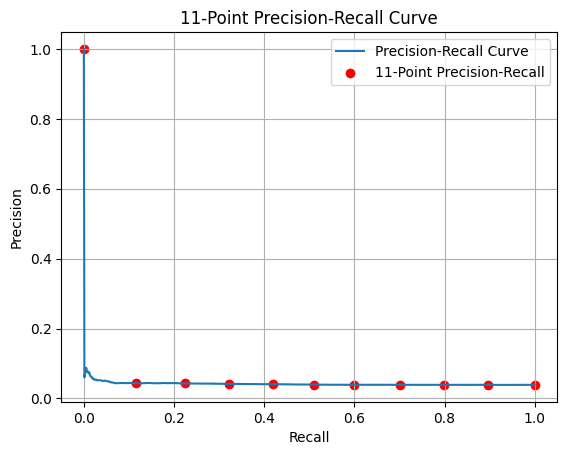

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Perform a left join on results_df and expected_df
merged_df = results_df.merge(expected_df, on=['QueryNumber', 'DocNumber'], how='left')

# Sort the merged_df by Rank in ascending order
sorted_df = merged_df.sort_values(by='Rank')

threshold = 0  # Adjust the threshold as needed
# Convert DocVotes to binary classification labels
labels = np.where(sorted_df['DocVotes'] > threshold, 1, 0)

# Convert DocVotes to binary classification labels
labels = np.where(sorted_df['DocVotes'] >= threshold, 1, 0)

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(labels, -sorted_df['Rank'])

# Calculate the 11-point precision and recall values
num_points = 11
step = int(len(precision) / (num_points - 1))
indices = list(range(0, len(precision), step))
indices[-1] = len(precision) - 1
precision_11pt = precision[indices]
recall_11pt = recall[indices]

# Plot the precision-recall curve
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.scatter(recall_11pt, precision_11pt, color='red', marker='o', label='11-Point Precision-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('11-Point Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()
